In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "/content/drive/MyDrive/Spring_2023_Project/COMS_572_Source_Code/CIFAR10"

/content/drive/MyDrive/Spring_2023_Project/COMS_572_Source_Code/CIFAR10


In [3]:
## load package
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# load build-in dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
## reshape and normalize data
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)


In [7]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

In [8]:
train_arr_75 = [tf.image.resize(img, (96, 96)) for img in x_train]
train_arr_75 = np.array(train_arr_75)
train_arr_75.shape

(50000, 96, 96, 3)

In [9]:
test_arr_75 = [tf.image.resize(img, (96, 96)) for img in x_test]
test_arr_75 = np.array(test_arr_75)
test_arr_75.shape

(10000, 96, 96, 3)

In [10]:
## define the model architecture

model = Sequential()
model.add(tf.keras.applications.VGG19(input_shape = (96, 96, 3), 
                                include_top = False, 
                                weights = 'imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [11]:
model.layers[0].trainable=False

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 128)               589952    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=opt,
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
  )

In [14]:
x_split_train, x_split_validation, y_split_train, y_split_validation = train_test_split(train_arr_75,y_train_one_hot, train_size=0.8, random_state=1)

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3)

In [16]:
## Trainning the model Stage 1
with tf.device('/device:GPU:0'):
  history1 = model.fit(x_split_train, y_split_train, validation_data=(x_split_validation, y_split_validation), epochs=10, verbose=2, callbacks=[reduce_lr])

Epoch 1/2
1250/1250 - 64s - loss: 1.0784 - categorical_accuracy: 0.6288 - val_loss: 0.9710 - val_categorical_accuracy: 0.6637 - lr: 0.0010 - 64s/epoch - 51ms/step
Epoch 2/2
1250/1250 - 49s - loss: 0.8322 - categorical_accuracy: 0.7117 - val_loss: 0.9091 - val_categorical_accuracy: 0.6905 - lr: 0.0010 - 49s/epoch - 39ms/step


In [17]:
model.save('epoch10_stage_1_CIFAR10_VGG_build_model.h5')

In [18]:
stage_1_lr = history1.history['lr']
stage_1_lr = np.array(stage_1_lr)

In [19]:
np.savetxt('epoch10_stage_1_lr.txt', stage_1_lr, fmt='%f')

In [20]:
def loss_diagnostics(history):
    # plot loss
    plt.plot(history.history['loss'], color='blue', label='Train')
    plt.plot(history.history['val_loss'], color='orange', label='Validation')
    plt.legend()

In [21]:
def accuracy_diagnostics(history):
    plt.plot(history.history['categorical_accuracy'], color='blue', label='Train')
    plt.plot(history.history['val_categorical_accuracy'], color='orange', label='Validation')
    plt.legend()

In [22]:
history1.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

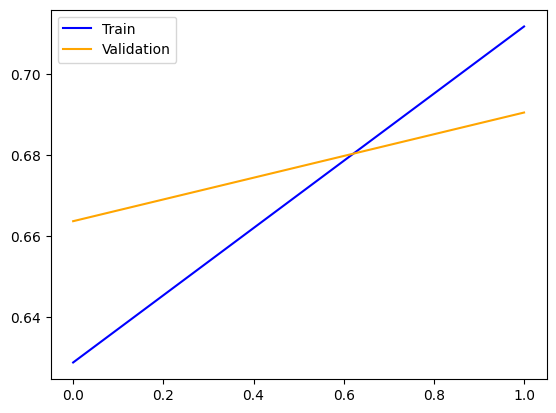

In [23]:
accuracy_diagnostics(history1)

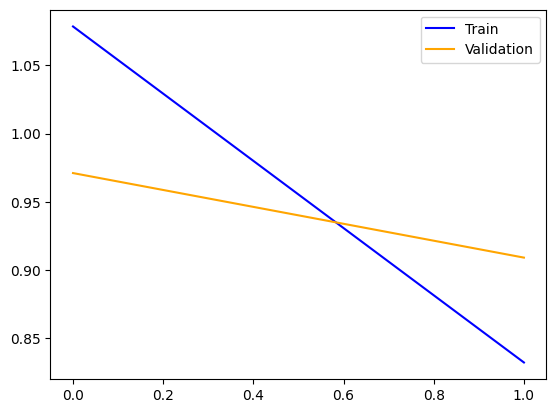

In [24]:
loss_diagnostics(history1)